In [ ]:
import quadprog
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import numpy as np
import pandas as pd
from numpy.linalg import multi_dot as mdot
from numpy import dot
from numpy import divide
from numpy.linalg import inv

## Solving for $A_{vv}$

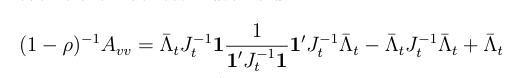

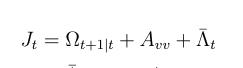

In [ ]:
# Setup
rho = 1-np.exp(-0.02/260)
Omega_t_plus_1 = np.array([[.2, .4, .6],
                           [.2, 40, 3],
                           [.1, .9, 5]])
gamma_D = 8.4e-4
Lambda_t = (gamma_D*Omega_t_plus_1)/(1-rho)



Avv_guess = np.array([[12, 0.16459002, 0.10984029],
                      [0.16459002, 0.19736949, 0.66823957],
                      [0.0002, 123, 0.48578228]])


p = Omega_t_plus_1.shape[0]
gamma = 2
ones = np.ones((p, 1))

In [ ]:
def J_t_inv(Avv):
    Avv = np.reshape(Avv, (p, p))
    return inv(Omega_t_plus_1 + Avv + Lambda_t)

In [ ]:
def LHS(Avv):
    Avv = np.reshape(Avv, (p, p))
    return (1/(1-rho))*Avv

In [ ]:
def RHS(Avv):
    Avv = np.reshape(Avv, (p, p))
    return mdot([Lambda_t, J_t_inv(Avv), ones, 1/(mdot([ones.T, J_t_inv(Avv), ones])), ones.T, J_t_inv(Avv), Lambda_t])-mdot([Lambda_t, J_t_inv(Avv), Lambda_t]) + Lambda_t

In [ ]:
def compare_sides(Avv):
    Avv = np.reshape(Avv, (p, p))
    Avv = np.triu(Avv)
    Avv = Avv.T + Avv - np.diag(np.diag(Avv))    # Enforcing a diagonal
    Left = LHS(Avv)
    Right = RHS(Avv)
    diff = np.abs(Left-Right)**2
    return np.sum(diff)

In [ ]:
def solve_Avv():
    options = {"maxiter": 4000, "ftol": 11e-23}
    res =minimize(fun = compare_sides, 
             x0 = Avv_guess,
            method = 'SLSQP',
            options = options,
            tol = 1e-13)
    return res

In [ ]:
res = solve_Avv()

In [ ]:
res

In [ ]:
Avv = np.reshape(res.x, (p, p))
Avv = np.triu(Avv)
Avv = Avv.T + Avv - np.diag(np.diag(Avv))

In [ ]:
LHS(Avv)-RHS(Avv)

In [ ]:
LHS(Avv)

In [ ]:
RHS(Avv)

In [ ]:
Avv

## Solving for $A_{v\textbf{1}}$

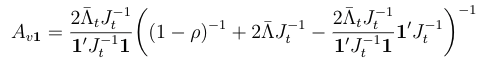

In [ ]:
fraction = (2*dot(Lambda_t, J_t_inv(Avv)))/(mdot([ones.T, J_t_inv(Avv), ones]))

In [ ]:
ones.T

In [ ]:
dot(ones.T, J_t_inv(Avv))

In [ ]:
big_paranthesis = inv((1-rho)**(-1)+2*dot(Lambda_t, J_t_inv(Avv))-mdot([fraction, ones, ones.T, J_t_inv(Avv)]))

In [ ]:
big_paranthesis

In [ ]:
Av1 = dot(big_paranthesis, fraction)

## Solving for $A_{\textbf{1}\textbf{1}}$

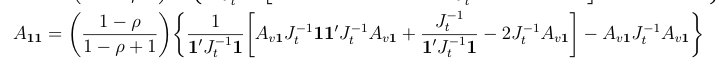

In [ ]:
first_paranthesis = (1-rho)/(1-rho+1)

In [ ]:
square_brackets = mdot([Av1, J_t_inv(Avv), ones, ones.T, J_t_inv(Avv), Av1])+J_t_inv(Avv)/mdot([ones.T, J_t_inv(Avv), ones]) - 2*dot(J_t_inv(Avv), Av1)

In [ ]:
curly_brackets = (1/mdot([ones.T, J_t_inv(Avv), ones]))*square_brackets-mdot([Av1, J_t_inv(Avv), Av1])

In [ ]:
A11 = dot(first_paranthesis, curly_brackets)

In [ ]:
A11